# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib
import matplotlib.pyplot as plt

# Settings

In [2]:
# To view all generated results
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 500)
plt.rcParams.update({'figure.max_open_warning': 0})

# Ignore pandas chained assignment errors
pd.options.mode.chained_assignment = None

# Widen the Jupyter Notebook as much as possible
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Import Data

In [3]:
# Import data
df = pd.read_csv('Wellbeing and Lifestyle\Wellbeing_and_lifestyle_data_Kaggle.csv', index_col = None, header = 0 )
df.head()

,Timestamp,FRUITS_VEGGIES,DAILY_STRESS,PLACES_VISITED,CORE_CIRCLE,SUPPORTING_OTHERS,SOCIAL_NETWORK,ACHIEVEMENT,DONATION,BMI_RANGE,TODO_COMPLETED,FLOW,DAILY_STEPS,LIVE_VISION,SLEEP_HOURS,LOST_VACATION,DAILY_SHOUTING,SUFFICIENT_INCOME,PERSONAL_AWARDS,TIME_FOR_PASSION,WEEKLY_MEDITATION,AGE,GENDER,WORK_LIFE_BALANCE_SCORE
0,7/7/15,3,2,2,5,0,5,2,0,1,6,4,5,0,7,5,5,1,4,0,5,36 to 50,Female,609.5
1,7/7/15,2,3,4,3,8,10,5,2,2,5,2,5,5,8,2,2,2,3,2,6,36 to 50,Female,655.6
2,7/7/15,2,3,3,4,4,10,3,2,2,2,2,4,5,8,10,2,2,4,8,3,36 to 50,Female,631.6
3,7/7/15,3,3,10,3,10,7,2,5,2,3,5,5,0,5,7,5,1,5,2,0,51 or more,Female,622.7
4,7/7/15,5,1,3,3,10,4,2,4,2,5,0,5,0,7,0,0,2,8,1,5,51 or more,Female,663.9


In [4]:
# View data
df.info()

# Observation:
# 1. No missing values
# 2. DAILY_STRESS column has inaccurate data type, it should be int64
# 3. To remove column 'Timestamp' as it is not material to the analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15972 entries, 0 to 15971
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Timestamp                15972 non-null  object 
 1   FRUITS_VEGGIES           15972 non-null  int64  
 2   DAILY_STRESS             15972 non-null  object 
 3   PLACES_VISITED           15972 non-null  int64  
 4   CORE_CIRCLE              15972 non-null  int64  
 5   SUPPORTING_OTHERS        15972 non-null  int64  
 6   SOCIAL_NETWORK           15972 non-null  int64  
 7   ACHIEVEMENT              15972 non-null  int64  
 8   DONATION                 15972 non-null  int64  
 9   BMI_RANGE                15972 non-null  int64  
 10  TODO_COMPLETED           15972 non-null  int64  
 11  FLOW                     15972 non-null  int64  
 12  DAILY_STEPS              15972 non-null  int64  
 13  LIVE_VISION              15972 non-null  int64  
 14  SLEEP_HOURS           

# Data Cleansing

In [5]:
# Check for duplicates across all columns
len(df[df.duplicated()])

# Duplicates here might be due to multiple submission by the same respondent

482

In [6]:
# Remove duplicates
df.drop_duplicates(inplace=True)

# Check for duplicates across all columns again
len(df[df.duplicated()])

0

In [7]:
# Remove unuseful column
df.drop(columns = 'Timestamp', axis = 1, inplace = True)

In [8]:
# View values under column DAILY_STRESS
df['DAILY_STRESS'].value_counts()

# Observation:
# - 1/1/00 is an inaccurate value

3         4230
2         3302
4         2903
1         2409
5         1987
0          658
1/1/00       1
Name: DAILY_STRESS, dtype: int64

In [9]:
# Check for work life balance score for DAILY_STRESS == 1/1/00
df[['DAILY_STRESS','WORK_LIFE_BALANCE_SCORE']][df['DAILY_STRESS']=='1/1/00']

# Info:
# - Work life balance scoring used for the survey:
#  - Poor: Below 550
#  - Good: 550 - 700
#  - Excellent: Above 700

# Action:
# - Since this response's score is 682.6 which categorised as 'Good', the average value of DAILY_STRESS based on other response with 'Good' score will be assigned

,DAILY_STRESS,WORK_LIFE_BALANCE_SCORE
10005,1/1/00,682.6


In [10]:
# Set dtype
df['DAILY_STRESS'] = pd.to_numeric(df['DAILY_STRESS'], errors='coerce')

# Assign average value
df.loc[df['DAILY_STRESS'] == '1/1/00','DAILY_STRESS'] = round(df[['WORK_LIFE_BALANCE_SCORE']][(df['WORK_LIFE_BALANCE_SCORE'] >= 550) & (df['WORK_LIFE_BALANCE_SCORE'] < 700)].mean())

## Data Banding

### Banding on Response Scale

In [11]:
# To group values under columns with response choices ranging from 1 - 10
def RESPONSE_SCR_BAND(x):
    
    '''
    INPUT:
    x - Values in selected columns
    
    OUTPUT:
    Band for 'x' based on its value
    '''
    # Banding of the values
    if (x >= 0) & (x < 3):
        return ('a. 0-2')
    elif (x >= 3) & (x < 6):
        return ('b. 3-5')
    elif (x >= 6) & (x < 9):
        return ('c. 6-8')
    elif (x >= 9) & (x <= 10):
        return ('d. 9-10')
    else:
        return ('N')

# List of columns to be band
cols = ['PLACES_VISITED', 'CORE_CIRCLE', 'SUPPORTING_OTHERS', 'SOCIAL_NETWORK', 'ACHIEVEMENT','TODO_COMPLETED', 'FLOW', 'DAILY_STEPS', 'LIVE_VISION', 'SLEEP_HOURS', 'LOST_VACATION', 'DAILY_SHOUTING','PERSONAL_AWARDS', 'TIME_FOR_PASSION', 
        'WEEKLY_MEDITATION']

for col in cols:
    df[col + '_BAND'] = df[col].apply(RESPONSE_SCR_BAND)

    
# Sample check one of the columns
df.PLACES_VISITED_BAND.value_counts().sort_index()

a. 0-2     3960
b. 3-5     5047
c. 6-8     2781
d. 9-10    3702
Name: PLACES_VISITED_BAND, dtype: int64

In [12]:
# View numerical distribution
df.describe()

,FRUITS_VEGGIES,DAILY_STRESS,PLACES_VISITED,CORE_CIRCLE,SUPPORTING_OTHERS,SOCIAL_NETWORK,ACHIEVEMENT,DONATION,BMI_RANGE,TODO_COMPLETED,FLOW,DAILY_STEPS,LIVE_VISION,SLEEP_HOURS,LOST_VACATION,DAILY_SHOUTING,SUFFICIENT_INCOME,PERSONAL_AWARDS,TIME_FOR_PASSION,WEEKLY_MEDITATION,WORK_LIFE_BALANCE_SCORE
count,15490.000000,15489.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000
mean,2.922466,2.792304,5.225823,5.513170,5.619496,6.489606,4.000194,2.716333,1.409038,5.749645,3.190252,5.715946,3.752163,7.038476,2.891995,2.923951,1.730536,5.710394,3.321304,6.222660,666.841233
std,1.443356,1.369373,3.315740,2.839156,3.244341,3.084922,2.760281,1.851438,0.491672,2.623108,2.355849,2.887100,3.225963,1.198948,3.686959,2.676001,0.443696,3.091236,2.728343,3.017574,45.001295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,480.000000
25%,2.000000,2.000000,2.000000,3.000000,3.000000,4.000000,2.000000,1.000000,1.000000,4.000000,1.000000,3.000000,1.000000,6.000000,0.000000,1.000000,1.000000,3.000000,1.000000,4.000000,636.000000
50%,3.000000,3.000000,5.000000,5.000000,5.000000,6.000000,3.000000,3.000000,1.000000,6.000000,3.000000,6.000000,3.000000,7.000000,0.000000,2.000000,2.000000,5.000000,3.000000,6.000000,667.900000
75%,4.000000,4.000000,8.000000,8.000000,10.000000,10.000000,6.000000,5.000000,2.000000,8.000000,5.000000,8.000000,5.000000,8.000000,5.000000,4.000000,2.000000,9.000000,5.000000,10.000000,698.500000
max,5.000000,5.000000,10.000000,10.000000,10.000000,10.000000,10.000000,5.000000,2.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,10.000000,10.000000,10.000000,820.200000


# Data Exploration

In [13]:
# Business Questions;
# 1. Which age group is more stress?
# 2. Reason for being stress
# 3. What kind of lifestyle that people with lower stress level practice?
# 4. Is there any correlation between stress and achivement?

## Stress Level by Age Group

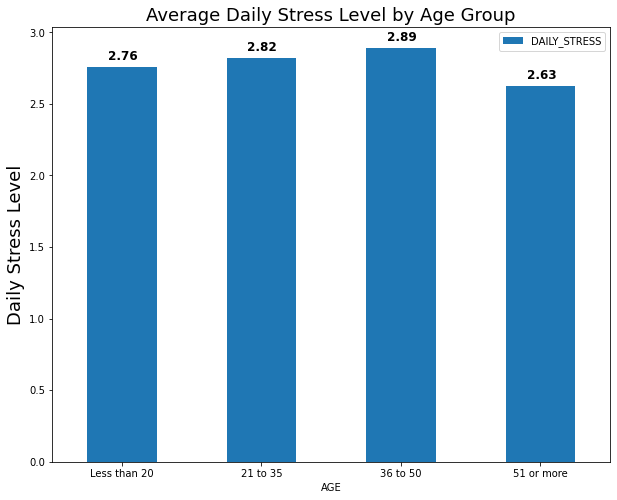

In [22]:
# Explore stress level by age group
def stress_level_by_age_group(df, col_stress, col_age):
    
    '''
    INPUT:
    df - main dataframe
    col_stress - column that contains respondent's daily stress level
    col_age - column that contains respondent's age

    OUTPUT:
    df_age_grp_stress_lvl - Daily Stress Level vs Age Group (%)
    '''
    # Custom sort column age
    df[col_age] = pd.Categorical(df[col_age], ordered=True, categories=['Less than 20','21 to 35','36 to 50','51 or more'])

    # Generate pivot table of Daily Stress Level vs Age Group
    df_new = pd.pivot_table(df, values=[col_stress], index=[col_age], aggfunc=np.mean)
    
    # Plot bar graph
    ax = df_new.plot(kind='bar', colormap='tab10', figsize=(10, 8))
    ax.set_alpha(0.8)
    ax.set_title("Average Daily Stress Level by Age Group", fontsize=18)
    ax.set_ylabel("Daily Stress Level", fontsize=18);
    plt.xticks(rotation=0)
    
    # set individual bar lables using above list
    for i in ax.patches:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_x()+0.15, i.get_height()+0.05, \
                str(round(i.get_height(), 2)), fontsize=12,
                    color='black', fontweight="bold")
          
    plt.show()



stress_level_by_age_group(df, 'DAILY_STRESS', 'AGE')

# Observation:
# - Respondents aged 36 to 50 has the highest average daily stress level followed by age 21 to 35.

## Lifestyle of Respondence with High Daily Stress Level

In [15]:
# Proportion of respondents aged 21 to 50 with daily stress level more than 4
round(len(df[(df['AGE'].str.contains('21 to 35|36 to 50')) & (df['DAILY_STRESS']>=4)])/len(df)*100,1)

21.8

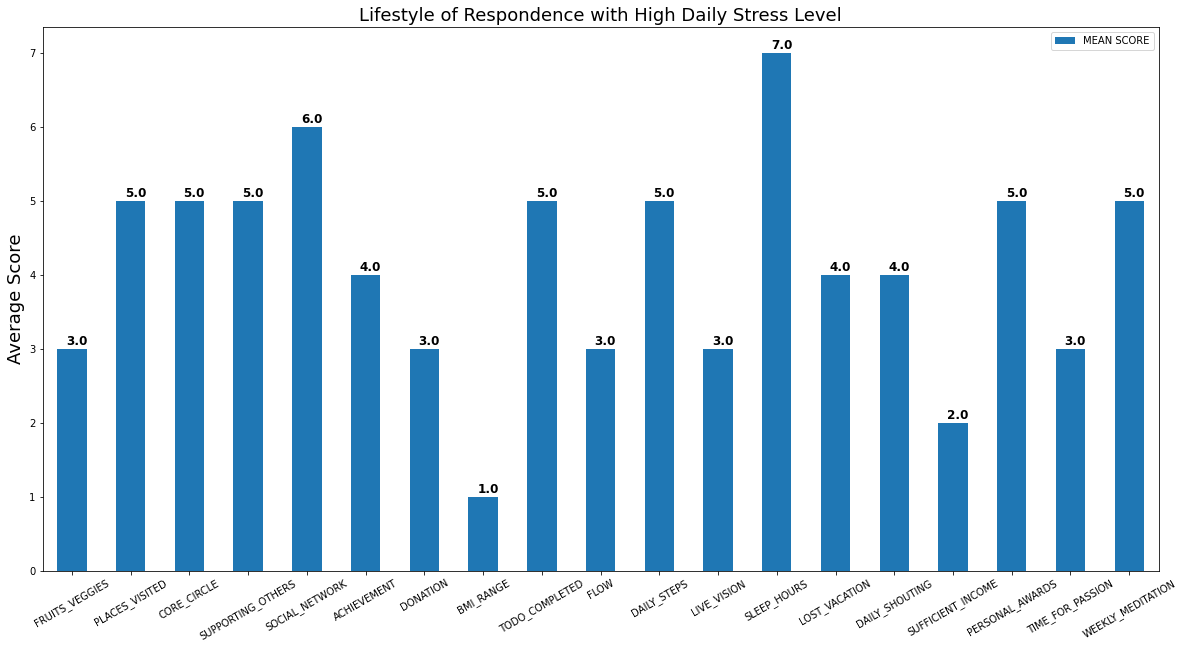

In [16]:
# Explore mean values of each column to idenfity causes of stress

def lifestyle_high_stress_lvl(df, col_stress, col_age):
    '''
    INPUT:
    df - main dataframe
    col_stress - column that contains respondent's daily stress level
    col_age - column that contains respondent's age

    OUTPUT:
    df_age_grp_stress_lvl - Daily Stress Level vs Age Group (%)
    '''
    
    # Create table of mean values of each column
    reason = pd.DataFrame(round(df[(df['AGE'].str.contains('21 to 35|36 to 50'))&(df['DAILY_STRESS']>=4)].mean(),0))
    reason.columns=['MEAN SCORE']
    
    # Remove unwanted columns
    reason.drop(reason.index[[1,20]],inplace=True)
    
    # Plot bar graph
    ax = reason.plot(kind='bar', colormap='tab10', figsize=(20, 10))
    ax.set_alpha(0.8)
    ax.set_title("Lifestyle of Respondence with High Daily Stress Level", fontsize=18)
    ax.set_ylabel("Average Score", fontsize=18);
    plt.xticks(rotation=30)
    
    # set individual bar lables using above list
    for i in ax.patches:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_x()+0.15, i.get_height()+0.05, str(round(i.get_height(), 2)), fontsize=12, color='black', fontweight="bold")
          
    plt.show()



lifestyle_high_stress_lvl(df, 'DAILY_STRESS', 'AGE')

# Observation:
# - Respondents aged 21 to 50 with high daily stress level lack of the following in their lifestyle:
#   -  Consumption of fruits & vegetables
#   -  Achievements
#   -  Contribution to other people
#   -  'Flow' - defined as the mental state in which a person is fully immersed in performing an activity then, experience a feeling of energized focus, full invovlvement and enjoyment in the process.
#   -  Life vision
#   -  Vacation
#   -  Time spent for passion

## Correlation Between Daily Stress Level & Achievement?

In [17]:
# Correlation between categorical variables
np.round(df[['DAILY_STRESS','ACHIEVEMENT']].corr(method='pearson').abs(), 2)

# Observation:
# - Weak positive correlation

,DAILY_STRESS,ACHIEVEMENT
DAILY_STRESS,1.00,0.11
ACHIEVEMENT,0.11,1.00
